In [1]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt

In [2]:
quandl.ApiConfig.api_key = 'PAUs5EodnTbMMKYzSwZV'

### Stock Market Confidence Indices - US Crash Confidence Index Data - Individual
A survey of the attitudes of weathly individual investors on the likelihood of a major stock market crash occuring within the next 6 months.  Higher values indicate higher precieved probability of a crash occuring. 

https://www.quandl.com/data/YALE-Yale-Department-of-Economics

In [54]:
crash = quandl.get('YALE/US_CONF_INDEX_CRASH_INDIV')
crash.head()

,Index Value,Standard Error
Date,,
1989-10-31,41.59,4.64
1996-10-31,33.08,4.13
1999-04-30,34.59,3.77
1999-10-31,32.29,4.77
2000-04-30,30.25,4.21


#### 1. Plot time series

Looking at the last eight years of data, it's evident that the overall trend is decreasing and that there are seasonal trends in the data.

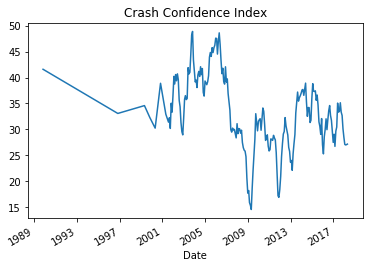

In [4]:
crash['Index Value'].plot()
plt.title('Crash Confidence Index')
plt.show()

#### 2. Make data set stationary by differencing.

Differencing with the lag value appears to have made the data stationary.  In ARIMA modeling, the I value should be set to at least 1.

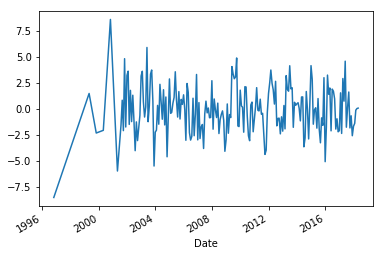

In [5]:
crash['diff_1'] = crash['Index Value'] - crash['Index Value'].shift(periods=1)
crash.diff_1.plot(y='diff_1')
plt.show()

Run Dickey-Fuller test on raw and differenced data to confirm stationary.  Null Hypothesis assumes non-stationarity.

From this test, we see the time series is not stationary because the p-value is > 0.05; however, differencing using a lag value of 1 makes the time series stationary (p < 0.5).

In [10]:
from statsmodels.tsa.stattools import adfuller

# raw data
x = crash['Index Value']
result = adfuller(x)
print('Data:')
print('ADF Statistic %f' % result[0])
print('p-value: %f' % result[1])

# differenced data
x_diff = crash['diff_1'].iloc[1:]
result = adfuller(x_diff)
print('\nDifferenced Data:')
print('ADF Statistic %f' % result[0])
print('p-value: %f' % result[1])

Data:
ADF Statistic -1.772920
p-value: 0.393987

Differenced Data:
ADF Statistic -5.791332
p-value: 0.000000


#### 3. Generate and Interpret an autocorrelation function (ACF).

ACF can help determine the MA parameter. Use stationary data x_diff for this.

The ACF shows no strong correlation with lag values, implying a MA(0) may be sufficient.  There is also a spike at lag 6, which could indicate some sort of cycle worth exploring.

In [15]:
import statsmodels
from statsmodels.tsa.stattools import pacf, acf

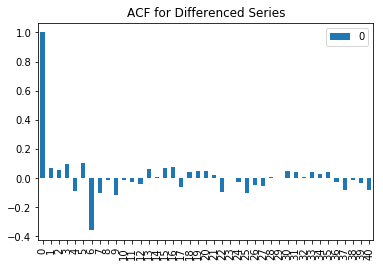

In [19]:
x_acf = pd.DataFrame(acf(x_diff))
x_acf.plot(kind='bar')
plt.title('ACF for Differenced Series')
plt.show()

#### 4. Generate and interpret a partial autocorrection function (PACF).

PACF can help determine the AR parameter.  Use stationary data for this.

PACF shows no strong correlations with lagged values.  There is again a spike at 6, potentially indicating some sort of cycle.

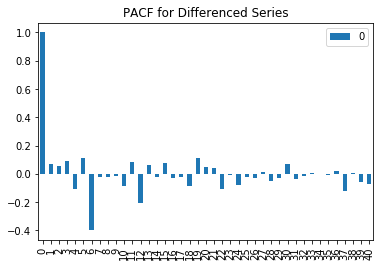

In [20]:
pacf = pd.DataFrame(pacf(x_diff))
pacf.plot(kind='bar')
plt.title('PACF for Differenced Series')
plt.show()

#### 5. Generate 5 ARIMA specifications (p, d, q) and evaluate their efficacy at modeling the data.

Use d=1 for all iterations to achieve stationarity.  For p and q values, check increasingly up to 6 where we see spikes in the both ACF and PACF.  For each iteration, print results summary and plot residuals as a scatter plot and histogram to evaluate for randomness and normal distribution. 

* (0,1,0) - error: list index out of range
* (1,1,1) - error: SVD did not converge
* (1,1,0)
* (0,1,1)
* (3,1,3) 
* (5,1,5) 
* (6,1,6)

#### (1, 1, 0) 

In [46]:
from statsmodels.tsa.arima_model import ARIMA

model_110 = ARIMA(crash['Index Value'], order=(1,1,0))
model_110_fit = model_110.fit()
print(model_110_fit.summary())
print('Residuals Description')
print(model_110_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:          D.Index Value   No. Observations:                  208
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -470.754
Method:                       css-mle   S.D. of innovations              2.326
Date:                Thu, 10 May 2018   AIC                            947.508
Time:                        17:13:54   BIC                            957.521
Sample:                    10-31-1996   HQIC                           951.557
                         - 04-30-2018                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0724      0.174     -0.417      0.677      -0.413       0.268
ar.L1.D.Index Value     0.0720      0.071      1.010      0.313      -0.068       0.212
                

C:\Users\mtracy\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\mtracy\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\mtracy\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


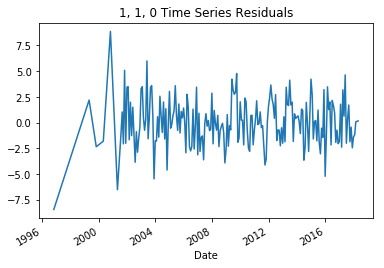

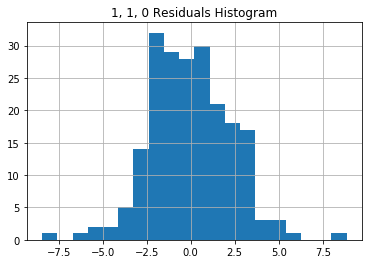

In [49]:
residuals_110 = pd.DataFrame(model_110_fit.resid)
residuals_110.plot(legend=False)
plt.title('1, 1, 0 Time Series Residuals')

residuals_110.hist(bins=20)
plt.title('1, 1, 0 Residuals Histogram')

plt.show()

#### (0, 1, 1) 

                             ARIMA Model Results                              
Dep. Variable:          D.Index Value   No. Observations:                  208
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -470.802
Method:                       css-mle   S.D. of innovations              2.327
Date:                Thu, 10 May 2018   AIC                            947.603
Time:                        19:37:26   BIC                            957.616
Sample:                    10-31-1996   HQIC                           951.652
                         - 04-30-2018                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0720      0.172     -0.419      0.676      -0.409       0.265
ma.L1.D.Index Value     0.0658      0.069      0.956      0.340      -0.069       0.201
                

C:\Users\mtracy\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\mtracy\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\mtracy\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


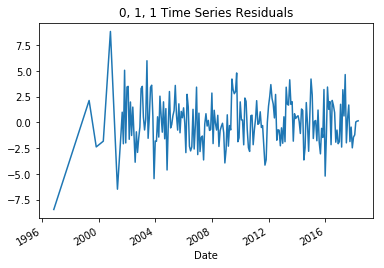

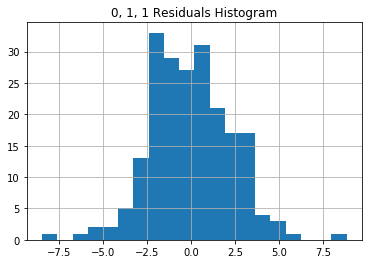

In [50]:
from statsmodels.tsa.arima_model import ARIMA

model_011 = ARIMA(crash['Index Value'], order=(0,1,1))
model_011_fit = model_011.fit()
print(model_011_fit.summary())
print('Residuals Description')
print(model_011_fit.resid.describe())

residuals_011 = pd.DataFrame(model_011_fit.resid)
residuals_011.plot(legend=False)
plt.title('0, 1, 1 Time Series Residuals')

residuals_011.hist(bins=20)
plt.title('0, 1, 1 Residuals Histogram')

plt.show()

#### (3, 1, 3)

C:\Users\mtracy\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\mtracy\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\mtracy\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:          D.Index Value   No. Observations:                  208
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -448.988
Method:                       css-mle   S.D. of innovations              2.061
Date:                Thu, 10 May 2018   AIC                            913.976
Time:                        21:13:11   BIC                            940.676
Sample:                    10-31-1996   HQIC                           924.772
                         - 04-30-2018                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0657      0.168     -0.390      0.697      -0.396       0.264
ar.L1.D.Index Value    -1.9995      0.071    -28.030      0.000      -2.139      -1.860
ar.L2.D.Index Va

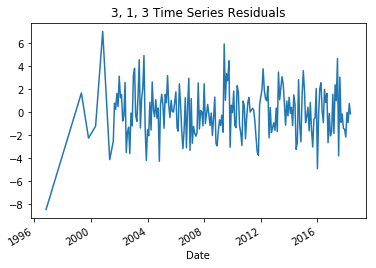

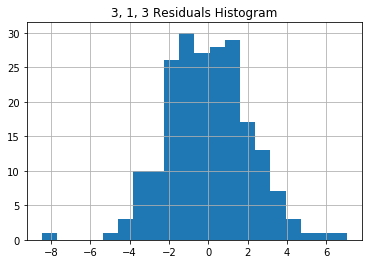

In [51]:
model_313 = ARIMA(crash['Index Value'], order=(3,1,3))
model_313_fit = model_313.fit()
print(model_313_fit.summary())
print('Residuals Description')
print(model_313_fit.resid.describe())

residuals_313 = pd.DataFrame(model_313_fit.resid)
residuals_313.plot(legend=False)
plt.title('3, 1, 3 Time Series Residuals')

residuals_313.hist(bins=20)
plt.title('3, 1, 3 Residuals Histogram')

plt.show()

#### (5, 1, 5)

C:\Users\mtracy\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\mtracy\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                             ARIMA Model Results                              
Dep. Variable:          D.Index Value   No. Observations:                  208
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -439.194
Method:                       css-mle   S.D. of innovations              1.984
Date:                Thu, 10 May 2018   AIC                            902.387
Time:                        21:16:15   BIC                            942.438
Sample:                    10-31-1996   HQIC                           918.582
                         - 04-30-2018                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0766      0.207     -0.370      0.712      -0.482       0.329
ar.L1.D.Index Value    -0.8604      0.166     -5.191      0.000      -1.185      -0.536
ar.L2.D.Index Va

C:\Users\mtracy\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


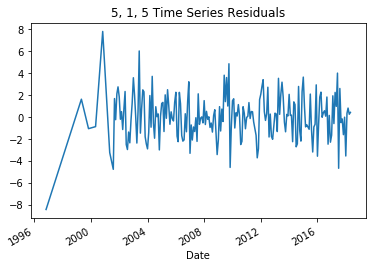

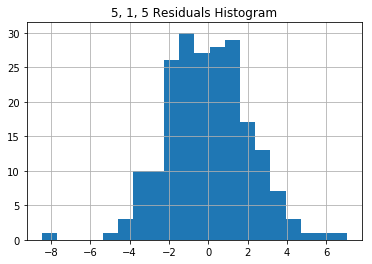

In [55]:
model_515 = ARIMA(crash['Index Value'], order=(5,1,5))
model_515_fit = model_515.fit()
print(model_515_fit.summary())
print('Residuals Description')
print(model_515_fit.resid.describe())

residuals_515 = pd.DataFrame(model_515_fit.resid)
residuals_515.plot(legend=False)
plt.title('5, 1, 5 Time Series Residuals')

residuals_313.hist(bins=20)
plt.title('5, 1, 5 Residuals Histogram')

plt.show()

#### (6, 1, 6)

C:\Users\mtracy\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\mtracy\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\mtracy\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:          D.Index Value   No. Observations:                  208
Model:                 ARIMA(6, 1, 6)   Log Likelihood                -434.563
Method:                       css-mle   S.D. of innovations              1.929
Date:                Thu, 10 May 2018   AIC                            897.125
Time:                        21:17:54   BIC                            943.851
Sample:                    10-31-1996   HQIC                           916.019
                         - 04-30-2018                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0536      0.028     -1.915      0.057      -0.108       0.001
ar.L1.D.Index Value     0.1263      0.136      0.926      0.355      -0.141       0.394
ar.L2.D.Index Va

C:\Users\mtracy\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


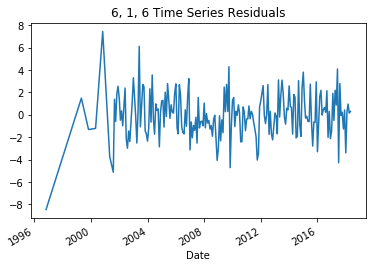

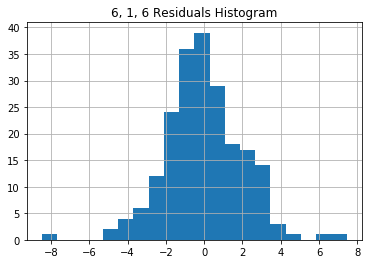

In [57]:
model_616 = ARIMA(crash['Index Value'], order=(6,1,6))
model_616_fit = model_616.fit()
print(model_616_fit.summary())
print('Residuals Description')
print(model_616_fit.resid.describe())

residuals_616 = pd.DataFrame(model_616_fit.resid)
residuals_616.plot(legend=False)
plt.title('6, 1, 6 Time Series Residuals')

residuals_616.hist(bins=20)
plt.title('6, 1, 6 Residuals Histogram')

plt.show()

Performance Summary:
* 110 and 011 had the highest AIC values (AIC = 947 for both), no significant coefficient values, and the confidence intervals included zero.  These metrics indicate neither model performs well.
* 313 had an AIC = 913 and significant coefficient p-values. Residual errors had a mean of 0 and show a normal distribution.
* 515 performed similar to 313 but had an ever lower AIC value = 902.
* 616 had to lowest AIC value, however the coefficients were not significant and the residuals were shifted slightly to the left relative to 313 and 515.

#### 6. Chose best specification and make the case for it as the logical model.

Results above indicate 313 or 515 may be the best configurations of the variations tested based on coefficients and residuals.  However, 616 had the lowest AIC value.  I'm not sure how to choose the best one as they all seem to perform fairly equally to each other.

In [62]:
import numpy as np

AIC616 = 897.125
AIC313 = 913.976
AIC515 = 902.238

loss_313 = np.exp((AIC616 - AIC313) / 2)
print(loss_313)

loss_515 = np.exp((AIC616 - AIC515) / 2)
print(loss_515)

0.00021920569990768548
0.0775757810792748


Comparing potential information lost, it looks like 515 may be the best model to use. 

--> confirm process for selecting best model configuration <--